# Cross Modal Retrieval

In this notebook, we are going to define and train a model which learns to map sentences and images into a common embedding space in order to be able to retrieve one from the other. We will be using image and captions from FLicker-8K dataset to train our network.

We learn a joint embedding iamge-sentence embedding space where sentences are encoded using a gated recurrent neural network. Image features from a deep CNN are projected into the embedding space of the GRU hidden states. A pairwise ranking loss is minimized to learn the rank images and their descriptions.

## Steps to run this npotebook

* Download the data and pre-trained files from [here](https://drive.google.com/open?id=1p2P-DgHjgpa_E5_hnK7UvEQ5D4WDJxF1)
* Copy the contents from the downloaded files and paste it to your 


In [50]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init
import torchvision
import torchvision.models as models
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.backends.cudnn as cudnn

from tqdm import *
from PIL import Image

from data import get_loader_single, get_transform, collate_fn, encode_data, i2t, t2i
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

ROOT = 'data/'
IMAGE_FOLDER = 'data/Flicker8k_Dataset'
VOCAB_PATH = 'vocab'
PRETRAINED = 'saves'
with open('{}/flickr_precomp_vocab.pkl'.format(VOCAB_PATH), 'rb') as f:
    vocab = pickle.load(f)
    
batch_size = 32

# Load and visualize data

The `get_data_loader` function returns training and validation DataLoaders that can load data efficiently and in specified batches. The function has the following parameters:
* `root`: path containg images and captions
* `vocab`: unique words contained in the descriptions.
* `batch_size`: number of images and descriptions in one batch of data

In [42]:
def get_loaders(root, vocab, batch_size):
        transform = get_transform('train')

        train_loader = get_loader_single(root, 'train',
                                        vocab, transform,
                                        batch_size=batch_size, shuffle=True,
                                        collate_fn=collate_fn)

        transform = get_transform('dev')
        
        val_loader = get_loader_single(root, 'dev',
                                    vocab, transform,
                                    batch_size=batch_size, shuffle=False,
                                    collate_fn=collate_fn)
        transform = get_transform('test')


        return train_loader, val_loader

In [43]:
train_loader, val_loader = get_loaders(IMAGE_FOLDER, vocab, batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


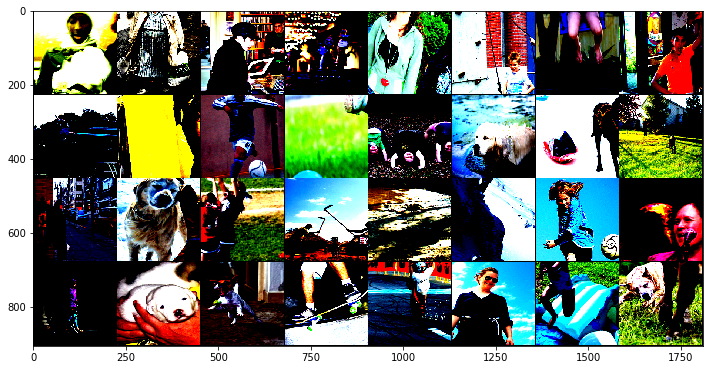

In [44]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
#np.transpose(npimg, (1, 2, 0))
# get some images from X
dataiter = iter(train_loader)
# the "_" is a placeholder for no labels
images, _, _, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

# Model

The model is composed of a image encoder network and text encoder network.

# Image Encoder

The Image encoder is composed of a pretrained VGG19 network and a Linear layer. 

<img src='images/vgg.gif'  width=60%/>

We take the output from last but one layer. The network sees a 224X244X3 image and passes it through
5 convolutional blocks, each of which down samples the image by a factor of 2. The output of the last linear layer from the VGG network acts as an input to another linear layer which embeds the image features to the cross-modal subspace.

In [45]:
def l2norm(X):
    """L2-normalize columns of X
    """
    norm = torch.pow(X, 2).sum(dim=1, keepdim=True).sqrt()
    X = torch.div(X, norm)
    return X

class EncoderImageFull(nn.Module):

    def __init__(self, embed_size, use_abs=False, no_imgnorm=False):
        """Load pretrained VGG19 and replace top fc layer."""
        super(EncoderImageFull, self).__init__()
        self.embed_size = embed_size
        self.no_imgnorm = no_imgnorm
        self.use_abs = use_abs
        # Load a pre-trained model
        
        self.cnn = models.__dict__['vgg19'](pretrained=True)
        self.cnn.features = nn.DataParallel(self.cnn.features)
        self.cnn.cuda()
        # Replace the last fully connected layer of CNN with a new one
        self.fc = nn.Linear(self.cnn.classifier._modules['6'].in_features,
                            embed_size)
        self.cnn.classifier = nn.Sequential(
            *list(self.cnn.classifier.children())[:-1])

        self.init_weights()

    def init_weights(self):
        """Xavier initialization for the fully connected layer
        """
        r = np.sqrt(6.) / np.sqrt(self.fc.in_features +
                                  self.fc.out_features)
        self.fc.weight.data.uniform_(-r, r)
        self.fc.bias.data.fill_(0)

    def forward(self, images):
        """Extract image feature vectors."""
        features = self.cnn(images)

        # normalization in the image embedding space
        features = l2norm(features)

        # linear projection to the joint embedding space
        features = self.fc(features)

        # normalization in the joint embedding space
        if not self.no_imgnorm:
            features = l2norm(features)
        if self.use_abs:
            features = torch.abs(features)

        # take the absolute value of the embedding (used in order embeddings)
        return features

# Text Encoder network

The text encoder network comprises of an [embedding](https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding) layer and a [GRU](https://pytorch.org/docs/stable/nn.html?highlight=gru#torch.nn.GRU). 

The embedding layer takes the size of the dictionary as the input dimension and outputs word embeddings in some specied dimension. We then pass each word embedding to the GRU, at each time step and then proceed to take the output from the hidden state at the last time step. 

The output from the GRU should have dimesion, same as the dimension of sub-space on which we are projecting the image.

In [46]:
class EncoderText(nn.Module):

    def __init__(self, vocab_size, word_dim, embed_size, use_abs=False):
        super(EncoderText, self).__init__()

        # word embedding
        self.embed = nn.Embedding(vocab_size, word_dim)
        self.embed_size = embed_size
        self.use_abs = use_abs
        # caption embedding
        self.rnn = nn.GRU(word_dim, embed_size, batch_first=True)

        self.init_weights()

    def init_weights(self):
        self.embed.weight.data.uniform_(-0.1, 0.1)

    def forward(self, x, lengths):
        """Handles variable size captions
        """
        # Embed word ids to vectors
        x = self.embed(x)
        packed = pack_padded_sequence(x, lengths, batch_first=True)

        # Forward propagate RNN
        out, _ = self.rnn(packed)

        # Reshape *final* output to (batch_size, hidden_size)
        padded = pad_packed_sequence(out, batch_first=True)
        I = torch.LongTensor(lengths).view(-1, 1, 1)
        I = Variable(I.expand(x.size(0), 1, self.embed_size)-1).cuda()
        out = torch.gather(padded[0], 1, I).squeeze(1)

        # normalization in the joint embedding space
        out = l2norm(out)

        # take absolute value, used by order embeddings
        if self.use_abs:
            out = torch.abs(out)

        return out

# Contrastive Loss

The objective is to learn representations with a small distance d between them for positive pairs, and greater distance than some margin value m for negative pairs.

<img src='images/eqn.gif'  width=60%/>

For positive pairs, the loss will be 0 only when the net produces representations for both the two elements in the pair with no distance between them, and the loss (and therefore, the corresponding net parameters update) will increase with that distance.

For negative pairs, the loss will be 0 when the distance between the representations of the two pair elements is greater than the margin m. But when that distance is not bigger than m, the loss will be positive, and net parameters will be updated to produce more distant representation for those two elements. The loss value will be at most m, when the distance between ra and rn is 0. The function of the margin is that, when the representations produced for a negative pair are distant enough, no efforts are wasted on enlarging that distance, so further training can focus on more difficult pairs.

In [47]:
class PairwiseRankingLoss(torch.nn.Module):

    def __init__(self, margin=1.0):
        super(PairwiseRankingLoss, self).__init__()
        self.margin = margin

    def forward(self, im, s):
        margin = self.margin
        # compute image-sentence score matrix
        scores = torch.mm(im, s.transpose(1, 0))
        diagonal = scores.diag()

        # compare every diagonal score to scores in its column (i.e, all contrastive images for each sentence)
        cost_s = torch.max(Variable(torch.zeros(scores.size()[0], scores.size()[1]).cuda()), (margin-diagonal).expand_as(scores)+scores)
        # compare every diagonal score to scores in its row (i.e, all contrastive sentences for each image)
        cost_im = torch.max(Variable(torch.zeros(scores.size()[0], scores.size()[1]).cuda()), (margin-diagonal).expand_as(scores).transpose(1, 0)+scores)

        for i in range(scores.size()[0]):
            cost_s[i, i] = 0
            cost_im[i, i] = 0

        return cost_s.sum() + cost_im.sum()

In [48]:
batch_size = 32
vocab_size = len(vocab)
print('Dictionary size: ' + str(vocab_size))
embed_size = 1024
img_dim = 4096
word_dim = 300
num_epochs = 100


Dictionary size: 3446


In [8]:
img_enc = EncoderImageFull(embed_size).to(device)
txt_enc = EncoderText(vocab_size, word_dim, embed_size).to(device)
params = list(txt_enc.parameters())
params += list(img_enc.fc.parameters())
criterion = PairwiseRankingLoss(margin=0.2)
optimizer = torch.optim.Adam(params, lr=0.0002)

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR
       decayed by 10 every 30 epochs"""
    lr = 0.0002 * (0.1 ** (epoch // 15))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
def validate(val_loader, txt_enc, img_enc):
    img_embs, cap_embs = encode_data(txt_enc, img_enc, val_loader)
    r1, r5, r10, medr = i2t(img_embs, cap_embs)
    r1i, r5i, r10i, medri = t2i(img_embs, cap_embs)
    score = r1 + r5 + r10 + r1i + r5i + r10i
    return r1
start_epoch=0
for epoch in range(start_epoch, num_epochs):
    adjust_learning_rate(optimizer, epoch)
    for i, batch in enumerate(tqdm(train_loader)):
        images, captions, lengths, ids = batch
        images = images.to(device)
        captions = captions.to(device)
        img_emb = img_enc(images)
        cap_emb = txt_enc(captions, lengths)
        loss = criterion(img_emb, cap_emb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    rsum = validate(val_loader, txt_enc, img_enc)
    print('Epochs: [%d]/[%d] AvgScore: %.2f Loss: %.2f'%(epoch, num_epochs, rsum, loss.item()))

Dictionary size: 3446


# Evaluation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


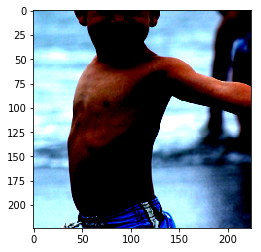

A boy stands in the ocean lifting up his shorts .

A little girl in a blue shirt is pointing at the water on the beach .

Two young girls are wading in the ocean wearing shorts and sweat shorts .

A young girl is pointing at water on a beach .

A boy in orange shorts is playing in the shallow part of the ocean .

Boy in yellow tank top laughing on a beach .

A laughing girl holding a bucket splashes in the ocean

A boy in shorts kicks while standing in shallow water .

Boy in sunglasses walking in the ocean .

A boy is carrying a black body board across the sand .



In [51]:
def load_image(file_name):
    image = Image.open(file_name)
    return image

def load_checkpoint(savefile):
    if os.path.exists(savefile):
        checkpoint = torch.load(savefile)
        return checkpoint
    else:
        print('No checkpoints available')
        
def get_captions():
    with open('{}/f8k_train_caps.txt'.format(ROOT), 'r') as f:
        lines = f.readlines()
    captions = [line.strip() for line in lines]
    return captions

def text_retrieval(image_embedding, cap_embs, captions) :
    scores = np.dot(image_embedding, cap_embs.T).flatten()
    sorted_args = np.argsort(scores)[::-1]
    sentences = [captions[a] for a in sorted_args[:10]]
    return sentences

savefile = 'saves/model_best_full.t7'   
img_enc = EncoderImageFull(1024, use_abs=True).to(device)
txt_enc = EncoderText(vocab_size, 300, 1024, use_abs=False).to(device)
img_enc.eval()
txt_enc.eval()
checkpoint = load_checkpoint(savefile)
img_enc.load_state_dict(checkpoint['model'][0])
txt_enc.load_state_dict(checkpoint['model'][1])
if not os.path.exists('saves/%s_joint_embs.pkl' %'flickr'):
    img_embs, cap_embs = encode_data(txt_enc, img_enc, train_loader)
    with open('%saves/s_joint_embs.pkl' %'flickr', 'wb') as f:
        pickle.dump([img_embs, cap_embs], f)
else:
    with open('saves/%s_joint_embs.pkl' %'flickr', 'rb') as f:
        embs = pickle.load(f)
        img_embs, cap_embs = embs[0], embs[1]
query_image = load_image('{}/106490881_5a2dd9b7bd.jpg'.format(IMAGE_FOLDER))
transform = get_transform('dev')
query_image = transform(query_image)
query_image_embedding = img_enc(query_image.unsqueeze(0)).data.cpu().numpy()
captions = get_captions()
ret = text_retrieval(query_image_embedding, cap_embs, captions)
plt.figure()
plt.imshow(np.transpose(query_image, (1, 2, 0)))
plt.show()
for each_ret in ret:
    print(each_ret+'\n')

